In [1]:
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[mujoco]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install gpytorch
!pip install river

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,109 kB of archives.
After this operation, 5,555 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig3.0 amd64 3.0.12-2.2ubuntu1 [1,109 kB]
Fetched 1,109 kB in 1s (1,120 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-2.2ubuntu1_amd64.deb ...
Unpacking swig3.0 (3.0.12-2.2ubuntu1) ...
Setting up swig3.0 (3.0.12-2.2ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 533.5 kB/s eta 0:00:00
   ━━━━━━━

In [2]:
import numpy as np
import pandas as pd

import gymnasium as gym
from gymnasium import utils
from gymnasium.wrappers import TransformReward, TransformObservation
from gymnasium.envs.mujoco.reacher_v4 import ReacherEnv
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.spaces import Box, Discrete
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import scipy
from scipy.stats import norm
from scipy.special import logsumexp

import gpytorch
import torch
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.utils.data import TensorDataset, DataLoader

from huggingface_sb3 import load_from_hub
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

from typing import Tuple

from collections import deque

import pickle

from river import drift

## Environments

In [3]:
env0 = gym.make("Reacher-v4") ## Training Environment
env1 = gym.make("Reacher-v4") ## Production Environment

In [11]:
DEFAULT_CAMERA_CONFIG = {"trackbodyid": 0}

class ReacherEnvDrifted(MujocoEnv, utils.EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 50,
    }

    def __init__(self, **kwargs):
        utils.EzPickle.__init__(self, **kwargs)
        observation_space = Box(low=-np.inf, high=np.inf, shape=(11,), dtype=np.float64)
        MujocoEnv.__init__(
            self,
            "./reacher_drifted.xml",
            2,
            observation_space=observation_space,
            default_camera_config=DEFAULT_CAMERA_CONFIG,
            **kwargs,
        )

    def step(self, a):
        vec = self.get_body_com("fingertip") - self.get_body_com("target")
        reward_dist = -np.linalg.norm(vec)
        reward_ctrl = -np.square(a).sum()
        reward = reward_dist + reward_ctrl

        self.do_simulation(a, self.frame_skip)
        if self.render_mode == "human":
            self.render()

        ob = self._get_obs()
        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return (
            ob,
            reward,
            False,
            False,
            dict(reward_dist=reward_dist, reward_ctrl=reward_ctrl),
        )

    def reset_model(self):
        qpos = (
            self.np_random.uniform(low=-0.1, high=0.1, size=self.model.nq)
            + self.init_qpos
        )
        while True:
            self.goal = self.np_random.uniform(low=-0.2, high=0.2, size=2)
            if np.linalg.norm(self.goal) < 0.2:
                break
        qpos[-2:] = self.goal
        qvel = self.init_qvel + self.np_random.uniform(
            low=-0.005, high=0.005, size=self.model.nv
        )
        qvel[-2:] = 0
        self.set_state(qpos, qvel)
        return self._get_obs()

    def _get_obs(self):
        theta = self.data.qpos.flat[:2]
        return np.concatenate(
            [
                np.cos(theta),
                np.sin(theta),
                self.data.qpos.flat[2:],
                self.data.qvel.flat[:2],
                self.get_body_com("fingertip") - self.get_body_com("target"),
            ]
        )



gym.register("ReacherDrifted-v4",
             ReacherEnvDrifted,
             max_episode_steps=50)

In [12]:
env2 = gym.make("ReacherDrifted-v4")

## Load Trained RL Model from HuggingFace

In [4]:
checkpoint = load_from_hub(
    repo_id = "fatcat22/ppo-reacher-v4",
    filename = "ppo-reacher-v4.zip",
)

model = PPO.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ppo-reacher-v4.zip:   0%|          | 0.00/151k [00:00<?, ?B/s]

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Training GP Monitor on Environment 0 (Training Environment)

In [6]:
observations = []
actions = []
transitions = [] # tuples of (St, DeltaSt)
rewards = []
dones = []

obs_t, _ = env0.reset()
observations.append(obs_t)

for i in range(20000):
  action_t, _state = model.predict(obs_t, deterministic=True)
  actions.append(action_t)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)

  done = terminated or truncated
  dones.append(done)

  observations.append(obs_tplus1)
  transitions.append(np.concatenate([obs_t, obs_tplus1-obs_t]))
  rewards.append(r_tplus1)

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env0.reset()

transitions_env0 = np.array(transitions)
actions_env0 = np.array(actions)

n_train = int(len(transitions_env0)*0.8)

In [7]:
X_train_env0, X_test_env0, y_train_env0, y_test_env0 = transitions_env0[:n_train], \
                                                       transitions_env0[n_train:], \
                                                       actions_env0[:n_train], \
                                                       actions_env0[n_train:]

scaler = StandardScaler()
scaler.fit(X_train_env0)
X_train_env0_scaled = scaler.transform(X_train_env0)
X_test_env0_scaled = scaler.transform(X_test_env0)


X_train_env0_tensor = torch.from_numpy(X_train_env0_scaled.astype("float32"))
X_test_env0_tensor = torch.from_numpy(X_test_env0_scaled.astype("float32"))
y_train_env0_tensor = torch.from_numpy(y_train_env0.astype("float32"))
y_test_env0_tensor = torch.from_numpy(y_test_env0.astype("float32"))

train_dataset = TensorDataset(X_train_env0_tensor, y_train_env0_tensor)
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True)
test_dataset = TensorDataset(X_test_env0_tensor, y_test_env0_tensor)
test_loader = DataLoader(test_dataset, batch_size=800, shuffle=False)

In [8]:
n_tasks = y_train_env0_tensor.size(1)
n_inducing = 100
kmeans = KMeans(n_clusters=n_inducing).fit(X_train_env0_scaled)
inducing_points = kmeans.cluster_centers_
inducing_points = torch.from_numpy(inducing_points.astype("float32"))
inducing_points = torch.concat([inducing_points]*n_tasks, dim=0)
inducing_points = inducing_points.reshape(n_tasks, n_inducing, -1)


class MultiActionPredictor(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):

        inducing_points = inducing_points

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([n_tasks])
        )

        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=n_tasks,
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks]),
                                       ard_num_dims=X_train_env0_tensor.size(1)),
            batch_shape=torch.Size([n_tasks])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model_gp_env0 = MultiActionPredictor(inducing_points)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
# Save the scaler
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [10]:
# Training

num_epochs = 3000


model_gp_env0 = model_gp_env0.to(device)
likelihood = likelihood.to(device)

model_gp_env0.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {"params": model_gp_env0.parameters()},
    {"params": likelihood.parameters()},
], lr=0.05)

#scheduler = MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma=0.5)
scheduler = ExponentialLR(optimizer, gamma=1-1e-3)

# loss object: VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model_gp_env0,
                                    num_data=y_train_env0_tensor.size(0))
mll_test = gpytorch.mlls.VariationalELBO(likelihood, model_gp_env0,
                                         num_data=y_test_env0_tensor.size(0))


best_loss_test = np.inf
losses_train = []
losses_test = []
#epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in range(num_epochs):
  model_gp_env0.train()
  likelihood.train()
  for _, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float()
    optimizer.zero_grad()
    output = model_gp_env0(x_batch)
    loss = -mll(output, y_batch)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses_train.append(loss.item())


  with torch.no_grad():
    model_gp_env0.eval()
    likelihood.eval()
    for _, (x_batch, y_batch) in enumerate(test_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      output = model_gp_env0(x_batch)
      loss = -mll_test(output, y_batch)
      losses_test.append(loss.item())
  print(f"""Iteration: {i+1}, train loss: {np.mean(losses_train)},
                     test loss: {np.mean(losses_test)}""")

  if np.mean(losses_test) < best_loss_test:
      torch.save(model_gp_env0, "model_gp_env0.pth")
      best_loss_test = np.mean(losses_test)
      print("Best model so far!")

Streaming output truncated to the last 5000 lines.
                     test loss: -5.9247207656525065
Best model so far!
Iteration: 1335, train loss: -6.024560038509469,
                     test loss: -5.924743773776494
Best model so far!
Iteration: 1336, train loss: -6.024585476599795,
                     test loss: -5.9247667474571815
Best model so far!
Iteration: 1337, train loss: -6.024610876566302,
                     test loss: -5.924789686771855
Best model so far!
Iteration: 1338, train loss: -6.024636238601381,
                     test loss: -5.924812591797568
Best model so far!
Iteration: 1339, train loss: -6.024661562807824,
                     test loss: -5.924835462611144
Best model so far!
Iteration: 1340, train loss: -6.024686849199152,
                     test loss: -5.924858299289177
Best model so far!
Iteration: 1341, train loss: -6.024712097931078,
                     test loss: -5.924881101908033
Best model so far!
Iteration: 1342, train loss: -6.024737308892

## Environment Drift Detection

In [13]:
class MultiActionPredictor(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):

        inducing_points = inducing_points

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([n_tasks])
        )

        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=n_tasks,
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks]),
                                       ard_num_dims=X_train_env0_tensor.size(1)),
            batch_shape=torch.Size([n_tasks])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model_gp_env0 = torch.load("model_gp_env0.pth")

with open("scaler.pkl", 'rb') as f:
  scaler = pickle.load(f)

In [14]:
env1_step = 3000
env2_step = 3000


total_step = env1_step + env2_step

#compute_mse_steps = 100


#actions_true = deque([], maxlen=compute_mse_steps)
#actions_predicted = deque([], maxlen=compute_mse_steps)


n_past_steps_to_store = 500
replay_buffer = deque([], maxlen=n_past_steps_to_store)
#mses_average = []
mses_production = []
loglikelihoods_production = []


env_current = env1
obs_t, _ = env_current.reset() # Initialize the environment

with torch.no_grad():

 for t in range(1, total_step+1):

  if t%500 == 0:
   print(f"step {t}")

  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)

  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_production.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))
  #loglikelihoods_production.append(multivariate_normal.logpdf(action_t,
  #                                                            mean = action_t_pre.mean.flatten().detach().cpu().numpy(),
  #                                                            cov = np.sqrt(action_t_pre.variance.flatten().detach().cpu().numpy())))
  #mses_buffer.append(mse(action_t, action_t_pre.reshape(-1)))



  done = terminated or truncated

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env_current.reset()

  if t==env1_step: ## Environment Drift Happens
    env_current = env2
    obs_t, _ = env_current.reset()

step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


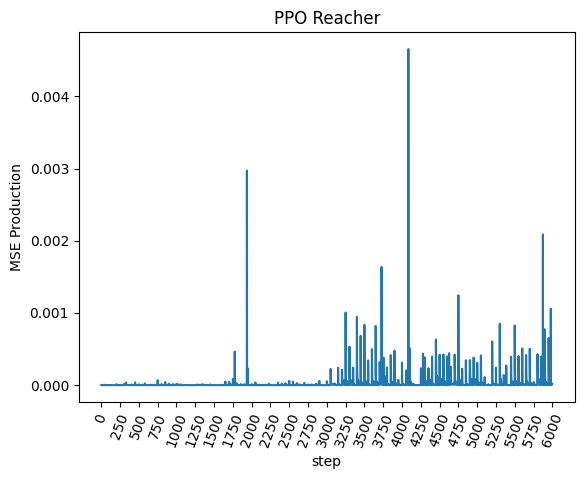

In [15]:
plt.plot(np.array(mses_production))
plt.xlabel("step")
plt.ylabel("MSE Production")
plt.title("PPO Reacher")
plt.xticks(np.arange(0, 6001, 250), rotation=70)
plt.show()

### Environment Drift Detection with Prob CUSUM

In [ ]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [ ]:
# Environment Drift Detection with CUSUM
env0_steps = 4000
window_size = 200
mses_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

#print(f"Reference mean: {np.mean(mses_reference)}, Reference std: {np.std(mses_reference)}")

mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)
mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref = sigma_ref,
                                   obs_ref=mses_reference_window,
                                   p_limit = p_limit)


false_alarms = 0
delay = 4000

for i,val in enumerate(mses_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="greater")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()
    drift_detector._reset(mses_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Drift Detected at: 3152 with value: 0.000491423299536109
False Alarms: 0, Delay: 152


### Page-Hinkley

In [ ]:
ph = drift.PageHinkley(mode="up", delta=0.005)

env0_steps = 4000
mses_reference = []
p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  ph.update(val)
  if ph.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 2833, input value: 37.60481262207031
Change detected at index 3102, input value: 3.7201318740844727
False Alarms: 1, Delay: 102


### ADWIN

In [ ]:
adwin = drift.ADWIN()

env0_steps = 4000
mses_reference = []
#p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break


print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


### KSWIN

In [ ]:
kswin = drift.KSWIN()

env0_steps = 4000
mses_reference = []
#p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break


print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 450, input value: 3.3867104053497314
Change detected at index 550, input value: 1.1483932733535767
Change detected at index 650, input value: 0.38727185130119324
Change detected at index 1852, input value: 0.35340335965156555
Change detected at index 2921, input value: 0.5228660106658936
Change detected at index 3024, input value: 0.33662649989128113
False Alarms: 5, Delay: 24
